## Time Series Data

This notebook demonstrates how to use __SynDiffix__ to capture the statistical properties of time-series data. 

SynDiffix itself does not synthesize time series data well in the sense that it does not for instance accurately replicate inter-event timing. Rather, it is necessary to extract the desired time series features __before__ synthesis.

For example, suppose we want to release the distribution of the number of events per person in a dataset. Conventional data synthesis products use a __synthesize-before-measure__ approach: they first synthesize the time-series data and then compute the number of events per person from the synthetic data. SynDiffix achieves much better accuracy by taking a __measure-before-synthesize__ approach: we first compute the number of events per person from the original data, generate a new dataset with this information, and then synthesize the new dataset.

In this notebook, we give a few examples of this approach.

### Setup

The `syndiffix` package requires Python 3.10 or later. Let's install it and other packages we'll need for the notebook.

In [2]:
%pip install -q syndiffix requests pandas

Note: you may need to restart the kernel to use updated packages.


### Loading the dataset

We'll start with the `trans` dataset from the Czech banking dataset. This dataset contains over one million banking transactions across 4500 bank accounts. A cleaned-up version is available at open-diffix.org.

In [3]:
import requests
import bz2
import pickle
def download_and_load(url):
    response = requests.get(url)
    data = bz2.decompress(response.content)
    df = pickle.loads(data)
    return df

# Usage
df_trans = download_and_load('http://open-diffix.org/datasets/trans.pbz2')
print(df_trans.head())

  trans_id account_id       date    type operation  amount  balance k_symbol  \
0   695247       2378 1993-02-01  PRIJEM     VKLAD   700.0    700.0      NaN   
1   171812        576 1993-02-01  PRIJEM     VKLAD   900.0    900.0      NaN   
2   207264        704 1993-02-01  PRIJEM     VKLAD  1000.0   1000.0      NaN   
3  1117247       3818 1993-02-01  PRIJEM     VKLAD   600.0    600.0      NaN   
4   579373       1972 1993-02-02  PRIJEM     VKLAD   400.0    400.0      NaN   

  bank account  
0  NaN     NaN  
1  NaN     NaN  
2  NaN     NaN  
3  NaN     NaN  
4  NaN     NaN  


### Identify the protected entity column

With time-series data, it is always necessary to configure the column that contains the identifier for the proected entity. If no such column exists, then it is necessary to create such a column (e.g. from a set of quasi-identifier columns).

The protected entity must be configured to protect anonymity. A protected entity like a person or an account can have an extreme number of rows (events) relative to other protected entities. SynDiffix has mechanisms to ensure that such protected entities cannot be inferred from the synthetic data.

The protected entity in the transactions table is the account, which is identified in the `account_id` column. Since the account is related to individual persons, we want to ensure that the privacy of individual accounts are protected.

## Distribution of maximum account balances

Suppose we want to see the distribution of the maximum account balance that each account had during the years covered by the data. To do this, we can first compute the maximum balance for each account from the original data, and generate a non-time-series (one row per account) dataset. We then generate synthetic data from the non-time-series dataset.

First measure the maximum balance per account and record that in a separate table. Note that it is critical that the `account_id` is carried over to the new table, so that it can continue to serve as the protected entity.

In [7]:
df_max_balance = df_trans.groupby('account_id')['balance'].max().reset_index()
df_max_balance.rename(columns={'balance': 'max_balance'}, inplace=True)
print(f"df_max_balance has {len(df_max_balance)} rows, {df_max_balance['account_id'].nunique()} distinct account_id, and columns:\n{list(df_max_balance.columns)}")

df_max_balance has 4500 rows, 4500 distinct account_id, and columns:
['account_id', 'max_balance']


Create a separate dataframe identifying the protected entity, and remove the protected entity from `df_max_balance` because we don't care about its statistics.

In [8]:
df_pid = df_max_balance[['account_id']]
df_max_balance = df_max_balance.drop(columns=["account_id"])

Finally, create the synthetic data.

In [10]:
from syndiffix import Synthesizer

df_max_balance_syn = Synthesizer(df_max_balance, pids=df_pid).sample()

Let's look at the data, comparing it with the original. First sort the data from largest to smallest max account balance.

In [11]:
df_max_balance = df_max_balance.sort_values(by=['max_balance'], ascending=False)
df_max_balance = df_max_balance.reset_index(drop=True)
df_max_balance.index.name = 'index'
df_max_balance_syn = df_max_balance_syn.sort_values(by=['max_balance'], ascending=False)
df_max_balance_syn = df_max_balance_syn.reset_index(drop=True)
df_max_balance_syn.index.name = 'index'

Then plot it.

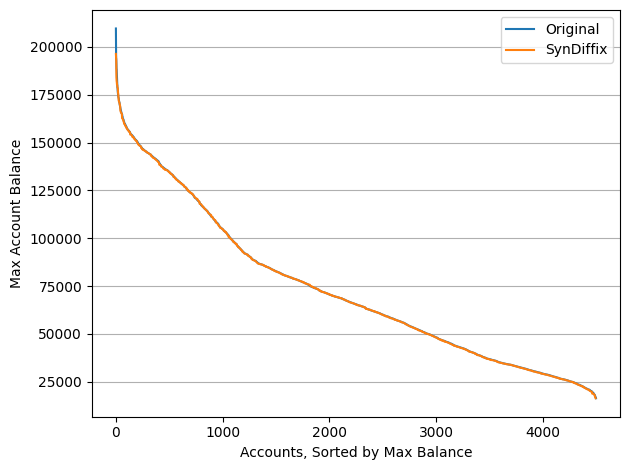

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
sns.lineplot(data=df_max_balance, x=df_max_balance.index.name, y='max_balance', ax=ax, label='Original')
sns.lineplot(data=df_max_balance_syn, x=df_max_balance_syn.index.name, y='max_balance', ax=ax, label="SynDiffix")
ax.grid(axis='y')
ax.legend()
ax.set(xlabel='Accounts, Sorted by Max Balance', ylabel='Max Account Balance')
plt.tight_layout()
plt.show()
plt.close()

The synthetic data almost perfectly matches the original data. The main exception is for a single account that has a slightly outlying max balance. SynDiffix reduces its max balance slightly so that it blends in with other accounts.

In [15]:
print(df_max_balance.head())
print(df_max_balance_syn.head())

       max_balance
index             
0         209637.0
1         196106.5
2         194119.3
3         193909.9
4         192662.5
         max_balance
index               
0      196340.217592
1      195438.920098
2      194893.243799
3      192893.788011
4      187249.451043


## Credit card type and balance

In this next example, we want to see if there is a relationship between credit card type and account balance. 892 of the 4500 bank accounts have credit cards. There are three classes of card, 'junior', 'classic', and 'gold'. Let's use average balance for this example.

In [21]:
# Compute the average balance per-account from the original data
df_avg_balance = df_trans.groupby('account_id')['balance'].mean().reset_index()
df_avg_balance.rename(columns={'balance': 'avg_balance'}, inplace=True)

We need to join the transaction table with the credit card table. To do this, we need to join the `card` table with a third table, `disp`, on `disp_id`, and then merge this with the `trans` table on `account_id`

In [17]:
df_card = download_and_load('http://open-diffix.org/datasets/card.pbz2')
print(df_card.head())

  card_id disp_id     type     issued
0    1005    9285  classic 1993-11-07
1     104     588  classic 1994-01-19
2     747    4915  classic 1994-02-05
3      70     439  classic 1994-02-08
4     577    3687  classic 1994-02-15


In [18]:
df_disp = download_and_load('http://open-diffix.org/datasets/disp.pbz2')
print(df_disp.head())

  disp_id client_id account_id       type
0       1         1          1      OWNER
1       2         2          2      OWNER
2       3         3          2  DISPONENT
3       4         4          3      OWNER
4       5         5          3  DISPONENT


In [29]:
import pandas as pd
df_disp_card = pd.merge(df_disp, df_card, on='disp_id', how='left')
df_bal_card = pd.merge(df_avg_balance, df_disp_card, on='account_id', how='left')
df_bal_card['card_type'] = df_bal_card['type_y']
df_bal_card = df_bal_card[['account_id', 'avg_balance', 'card_type']]
# We are only interested in accounts that have a credit card
df_bal_card = df_bal_card[df_bal_card['card_type'].isin(['gold', 'junior', 'classic'])]
print(df_bal_card.head())

   account_id   avg_balance card_type
9       10022  52006.024060   classic
18      10065  73529.315970   classic
21       1007  39365.620541    junior
22      10079  56108.403653   classic
25       1009  55702.646825   classic


Synthesize the `avg_balance` and `card_type table`

In [30]:
df_pid = df_bal_card[['account_id']]
df_bal_card = df_bal_card.drop(columns=["account_id"])
df_bal_card_syn = Synthesizer(df_bal_card, pids=df_pid).sample()

Let's look at the results.

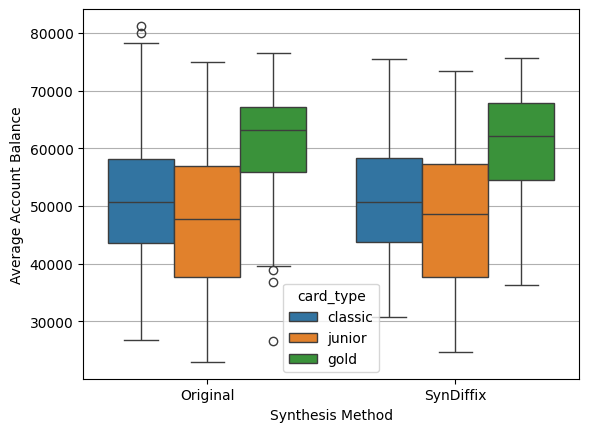

In [33]:
df_bal_card['method'] = "Original"
df_bal_card_syn['method'] = "SynDiffix"
df_all = pd.concat([df_bal_card, df_bal_card_syn])
fig, ax = plt.subplots()
sns.boxplot(x='method', y='avg_balance', hue='card_type', data=df_all, ax=ax)
ax.set_xlabel('Synthesis Method')
ax.set_ylabel('Average Account Balance')
ax.grid(axis='y')
plt.show()
plt.close()

In [38]:
medians = df_all.groupby(['method', 'card_type'])['avg_balance'].median().reset_index()
for card_type in ['junior', 'classic', 'gold']:
    med_orig = medians.loc[(medians['method'] == 'Original') & (medians['card_type'] == card_type), 'avg_balance'].values[0]
    med_syn = medians.loc[(medians['method'] == 'SynDiffix') & (medians['card_type'] == card_type), 'avg_balance'].values[0]
    print(f"Error for card type {card_type} is {abs(med_orig - med_syn)/med_orig}")

Error for card type junior is 0.021310974243243005
Error for card type classic is 0.0002641892878604202
Error for card type gold is 0.01438633954161776


The synthesized data is quite close to the original. The median value of the synthetic data for each card is within around 2% or less of the original data. SynDiffix correctly shows that gold card customers have a substantially higher average balance than classic card customers, which in turn have a slightly higher average balance than junior card customers.